# Приоритизация гипотез и анализ результатов A/B-теста

## Содержание  
1. [Описание проекта](#step1)
2. [Приоритизация гипотез](#step2)  
 2.1. [Применение фреймворка ICE](#s21)  
 2.2. [Применение фреймворка RICE](#s22)  
3. [Анализ A/B-теста](#step3)  
 3.1. [Предобработка данных](#s31)  
 3.2. [График кумулятивной выручки по группам.](#s32)  
 3.3. [График кумулятивного среднего чека по группам.](#s33)  
 3.4. [График относительного изменения кумулятивного среднего чека группы B к группе A.](#s34)  
 3.5. [График кумулятивной конверсии по группам.](#s35)  
 3.6. [График относительного изменения кумулятивной конверсии группы B к группе A.](#s36)  
 3.7. [Точечный график количества заказов по пользователям.](#s37)  
 3.8. [Расчет 95-го и 99-го перцентилей количества заказов на пользователя. Выбор границы для определения аномальных пользователей.](#s38)  
 3.9. [Точечный график стоимостей заказов.](#s39)  
 3.10. [Расчет 95-го и 99-го перцентилей стоимости заказов. Выбор границы для определения аномальных заказов.](#s310)  
 3.11. [Расчет статистической значимости различий в конверсии между группами по «сырым» данным](#s311)  
 3.12. [Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным](#s312)  
 3.13. [Расчет статистической значимости различий в конверсии между группами по «очищенным» данным](#s313)  
 3.14. [Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным](#s314)  
 3.15. [Решение по результатам теста](#s315)  
4. [Общий вывод](#step4)  

<a id='step1'></a>
## 1. Описание проекта

**Задача:** 
Приоритизировать гипотезы, подготовленные вместе с отделом маркетинга, запустить A/B-тест и проанализировать результаты.

**Данные:**  
Файл /datasets/hypothesis.csv.  
Hypothesis — краткое описание гипотезы;  
Reach — охват пользователей по 10-балльной шкале;  
Impact — влияние на пользователей по 10-балльной шкале;  
Confidence — уверенность в гипотезе по 10-балльной шкале;  
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале.  

Файл /datasets/orders.csv.  
transactionId — идентификатор заказа;  
visitorId — идентификатор пользователя, совершившего заказ;  
date — дата, когда был совершён заказ;  
revenue — выручка заказа;  
group — группа A/B-теста, в которую попал заказ.  

Файл /datasets/visitors.csv.  
date — дата;  
group — группа A/B-теста;  
visitors — количество пользователей в указанную дату в указанной группе A/B-теста.  

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl
np.warnings.filterwarnings('ignore')

In [2]:
mpl.rcParams['figure.figsize'] = (12,6)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150

[К содержанию](#Содержание)
<a id='step2'></a>
## 2. Приоритизация гипотез

In [3]:
hypothesis = pd.read_csv('datasets/hypothesis.csv')

In [4]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<a id='s21'></a>
**2.1. Применение фреймворка ICE**

In [5]:
hypothesis['ICE'] = (hypothesis['Impact']*hypothesis[
    'Confidence'])/hypothesis['Efforts']
hypothesis['ICE'] = hypothesis['ICE'].round(2)

In [6]:
hypothesis['ICE_priority'] = hypothesis['ICE'].rank(
    ascending=False).astype('int')

In [7]:
hypothesis.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,ICE_priority
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,1
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,2
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,4
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,5
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,6
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,7
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,9


<a id='s22'></a>
**2.2. Применение фреймворка RICE**

In [8]:
hypothesis['RICE'] = (hypothesis['Reach']*hypothesis[
    'Impact']*hypothesis['Confidence'])\
/hypothesis['Efforts']
hypothesis['RICE'] = hypothesis['RICE'].round(2)
hypothesis['RICE_priority'] = hypothesis['RICE'].rank(
    ascending=False).astype('int')

In [9]:
hypothesis.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,ICE_priority,RICE,RICE_priority
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,3,112.0,1
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,5,56.0,2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,2,40.0,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,4,40.0,3
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,1,16.2,5
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,8,9.0,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,6,4.0,7
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,7,4.0,7
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,9,3.0,9


In [10]:
cm = sns.light_palette("slateblue", reverse=True, as_cmap=True)

In [11]:
result = hypothesis[['Hypothesis', 'ICE_priority', 'RICE_priority']]
result.style.background_gradient(cmap=cm)

,Hypothesis,ICE_priority,RICE_priority
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",2,3
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",6,7
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",5,2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,6
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",9,9
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",7,7
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",4,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",3,1
8,"Запустить акцию, дающую скидку на товар в день рождения",1,5


### Вывод
Наиболее приоритетными гипотезами по методу ICE (в порядке убывания приоритета) оказались:    
- Запустить акцию, дающую скидку на товар в день рождения, 
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей,  
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок,   

по методу RICE:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок,  
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа,  
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей,  
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию. 

Расхождения вызваны тем, что показатель охвата `Reach` внес существенные поправки в расчеты.  
Гипотеза "Запустить акцию, дающую скидку на товар в день рождения" скорее всего окажет существенное влияние при средних усилиях, но изменения будут влиять только на тех пользователей, у которых в текущем периоде день рождения, то есть на сравнительно небольшую часть. Это и привело ее к выбыванию из топ-3.  
Гипотезы "Добавить блоки рекомендаций товаров на сайт интернет магазина..." и "Показать на главной странице баннеры с актуальными акциями и распродажами... " касаются изменений в целом на сайте, так что затронут большее количетсво пользователей. 

Я бы порекомендовала придерживаться результата, полученного по методу RICE, так как в данном случае используется более полная информация о гипотезах.

[К содержанию](#Содержание)
<a id='step3'></a>
## 3. Анализ A/B-теста

<a id='s31'></a>
**3.1. Предобработка данных**

In [12]:
orders = pd.read_csv('datasets/orders.csv')
orders_init = orders.copy()
visitors = pd.read_csv('datasets/visitors.csv')
visitors_init = visitors.copy()

In [13]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [14]:
orders.duplicated().sum()

0

In [15]:
orders = orders.rename(columns={'transactionId':'transaction_id',
                       'visitorId':'visitor_id'})

In [16]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [17]:
orders['transaction_id'] = orders['transaction_id'].astype('str')
orders['visitor_id'] = orders['visitor_id'].astype('str')
orders['date'] = pd.to_datetime(orders['date'], format="%Y-%m-%d")

In [18]:
orders['date'].describe()

count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

In [19]:
users_a = orders[orders['group']=='A']['visitor_id'].unique()
users_b = orders[orders['group']=='B']['visitor_id'].unique()

In [20]:
# проверяем, нет ли пользователей, оказавшихся в обеих группах
if_users_in_both_groups = [user in users_b for user in users_a]
sum(if_users_in_both_groups)

58

In [21]:
users_in_both_groups = users_a[if_users_in_both_groups]

In [22]:
# исключаем из анализа пользователей, оказавшихся в обеих группах
orders = orders[~(orders['visitor_id'].isin(users_in_both_groups))]

In [23]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [24]:
visitors.duplicated().sum()

0

In [25]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [26]:
visitors['date'] = pd.to_datetime(visitors['date'], format="%Y-%m-%d")

In [27]:
visitors['date'].describe()

count                      62
unique                     31
top       2019-08-02 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

### Вывод  
Доступны данные о 1197 заказах и агрегированные по дням данные о визитах за период с 1 по 31 августа 2019 года.  
Пропусков и дубликатов в данных не обнаружено.  
Переменные, содержащие даты, приведены к типу `datetime`.
Переменные, содержащие id заказов и пользователей, приведены к типу `object`.  
В ходе предобработки выявлены 58 пользователей, которые попали в обе группы. 
Поскольку по ним нельзя однозначно сказать, повлияло ли изменение на факт заказа, они исключены из дальнейшего анализа.

<a id='s32'></a>
**3.2. График кумулятивной выручки по группам**

In [28]:
dates_groups = orders[['date', 'group']].drop_duplicates(
).reset_index(drop=True)

In [29]:
dates_groups.head()

,date,group
0,2019-08-15,B
1,2019-08-15,A
2,2019-08-16,A
3,2019-08-16,B
4,2019-08-01,A


In [30]:
orders_aggregated = (dates_groups.apply(
    lambda x: orders[
        np.logical_and(orders['date']<=x['date'], orders['group']==x['group'])]
    .agg({'date':'max',
        'group':'max',
        'transaction_id':'nunique',
        'visitor_id':'nunique',
        'revenue':'sum'}), axis=1)
                     .sort_values(by=['date','group']))

In [31]:
visitors_aggregated = (dates_groups.apply(
    lambda x: visitors[
        np.logical_and(visitors['date']<=x['date'],
                      visitors['group']==x['group'])].agg(
    {'date':'max',
    'group':'max',
    'visitors':'sum'}), axis=1).sort_values(
by=['date', 'group']))

In [32]:
cumulative_data = pd.merge(orders_aggregated, visitors_aggregated,
                          left_on=['date', 'group'],
                          right_on=['date', 'group'])

In [33]:
cumulative_data.columns = [
    'date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [34]:
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [35]:
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][
    ['date', 'revenue', 'orders']
]
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][
    ['date', 'revenue', 'orders']
]

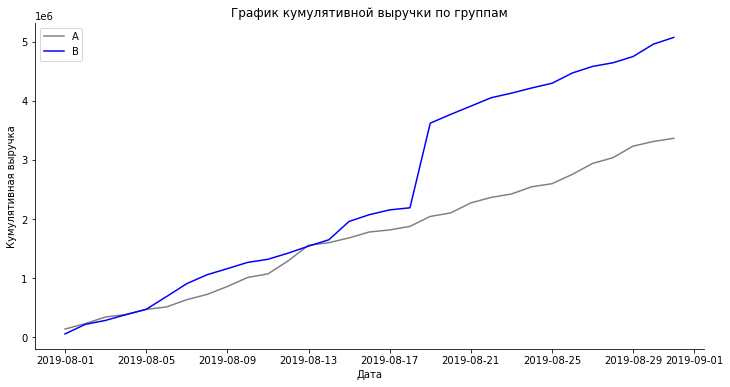

In [36]:
plt.title('График кумулятивной выручки по группам')
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'],
         label='A', color='gray')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'],
         label='B', color='blue')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.legend();

Выручка растет в течение всего времени проведения теста. Выручка в группе А растет равномерно, в группе B наблюдается резкий скачок между 17 и 21 августа. Возможно, в эти дни произошел резкий рост числа заказов или были несколько дорогих заказов. 

<a id='s33'></a>
**3.3. График кумулятивного среднего чека по группам**

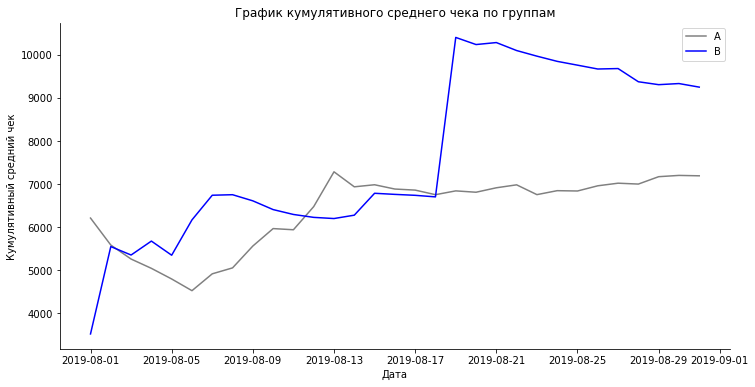

In [37]:
plt.title('График кумулятивного среднего чека по группам')
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/\
         cumulative_revenue_A['orders'], label='A',
        color='gray')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/\
         cumulative_revenue_B['orders'], label='B',
        color='blue')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.legend();

Средний чек группы А стабилизируется где-то после 17 августа, в то время как в группе B происходит резкое увеличение этого показателя. Видимо, в период, когда наблюдался  скачок выручки, были сделаны несколько дорогих заказов. После этого всплеска средний чек группы B начинает плавно снижаться.

<a id='s34'></a>
**3.4. График относительного изменения кумулятивного среднего чека группы A к группе B**

In [38]:
merged_cumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B,
                                                      on='date',
                                                      how='left',
                                                      suffixes=['A','B'])

In [39]:
merged_cumulative_revenue.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54
3,2019-08-04,388030,77,385740,68
4,2019-08-05,474413,99,475648,89


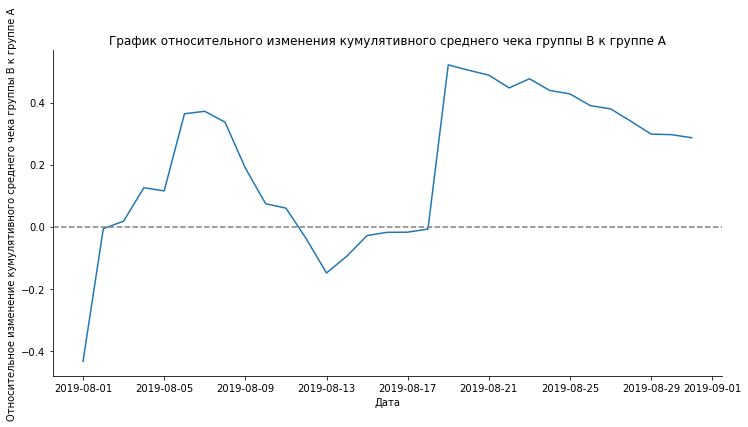

In [40]:
plt.title('График относительного изменения кумулятивного среднего чека \
группы B к группе A')
plt.plot(merged_cumulative_revenue['date'],
        (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue[
            'ordersB'])/\
        (merged_cumulative_revenue['revenueA']/merged_cumulative_revenue[
            'ordersA'])-1)
plt.xlabel('Дата')
plt.ylabel('Относительное изменение кумулятивного среднего чека \
группы B к группе A')
plt.axhline(0, color='gray', linestyle='--');

Видно резкое падение 13 августа и резкий скачок между 17 и 21.

<a id='s35'></a>
**3.5. Построим график кумулятивной конверсии**

In [41]:
cumulative_data['conversion'] = cumulative_data[
    'orders']/cumulative_data['visitors']

In [42]:
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

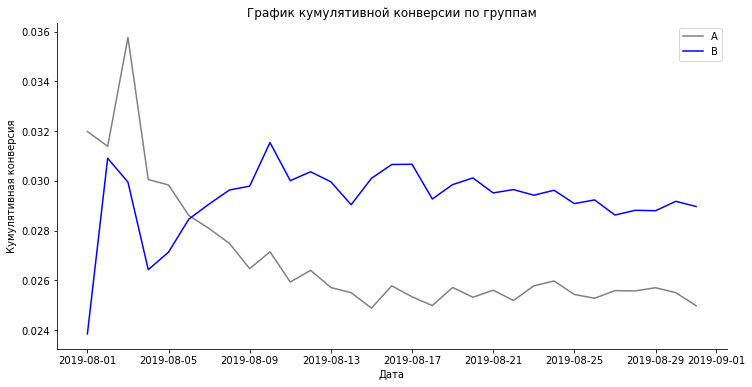

In [43]:
plt.title('График кумулятивной конверсии по группам')
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A',
        color='gray')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B',
        color='blue')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.legend();

Конврсия группы В выше конверсии группы A большую часть времени проведения теста.

<a id='s36'></a>
**3.6. График относительного различия кумулятивных конверсий.**

In [44]:
merged_cumulative_conversions = cumulative_data_A.merge(cumulative_data_B,
                                                       on='date',
                                                       how='left',
                                                       suffixes=['A','B'])

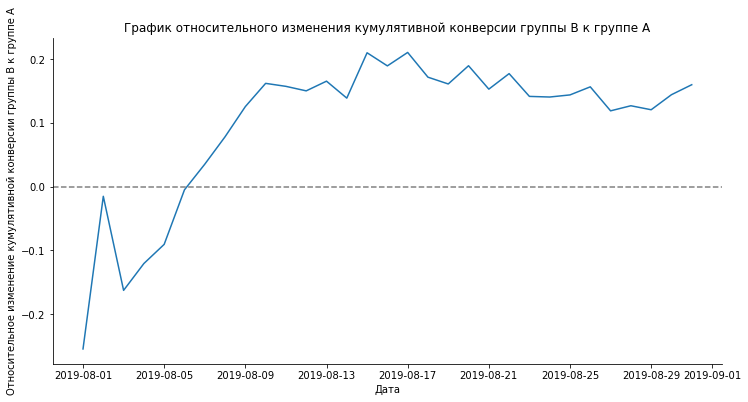

In [45]:
plt.title('График относительного изменения кумулятивной конверсии группы B \
к группе A')
plt.plot(merged_cumulative_conversions['date'],
        (merged_cumulative_conversions['conversionB']/\
         merged_cumulative_conversions['conversionA'])-1)
plt.xlabel('Дата')
plt.ylabel('Относительное изменение кумулятивной конверсии группы B \
к группе A')
plt.axhline(0, color='gray', linestyle='--');

Конверсия группы B начиная примерно с 10 августа и далее на всем протяжении теста выше.

Ранее построенные графики выручки и среднего чека показали, что в данных, возможно, есть аномалии.  
Для выявления аномалий построим точечный график количества заказов по пользователям. 

<a id='s37'></a>
**3.7. Точечный график количества заказов по пользователям**

In [46]:
orders_by_users = orders[['transaction_id', 'visitor_id']].groupby(
'visitor_id', as_index=False).agg({'transaction_id':'nunique'})

In [47]:
orders_by_users.sort_values('transaction_id', ascending=False).head()

,visitor_id,transaction_id
507,2988190573,3
376,249864742,3
442,2742574263,3
274,2108163459,3
749,3967698036,3


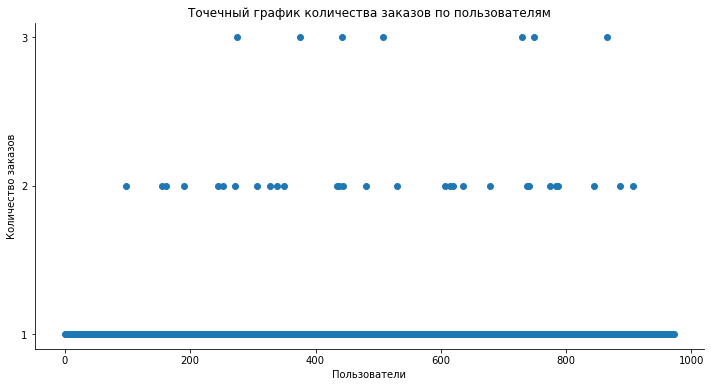

In [48]:
x_values = pd.Series(range(0, len(orders_by_users)))
plt.title('Точечный график количества заказов по пользователям')
plt.scatter(x_values, orders_by_users['transaction_id'])
plt.yticks(np.arange(orders_by_users['transaction_id'].min(),
                     orders_by_users['transaction_id'].max()+1, 1))
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов');

Судя по графику, подавляющее большинство клиентов делают по одному заказу, реже - 2-3.

<a id='s38'></a>
**3.8. Рассчитаем 95 и 99 перцентили количества заказов на пользователя.**

In [49]:
n_orders_percentiles = np.percentile(orders_by_users[
    'transaction_id'], [95, 99])
print(n_orders_percentiles)

[1. 2.]


Не более одного процента пользователей делают более двух заказов. Примем 2 заказа за нижнюю границу аномальных пользователей по числу заказов.

In [50]:
n_orders_lower_limit = n_orders_percentiles[1]

<a id='s39'></a>
**3.9. Построим точечный график стоимостей заказов.**

In [51]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


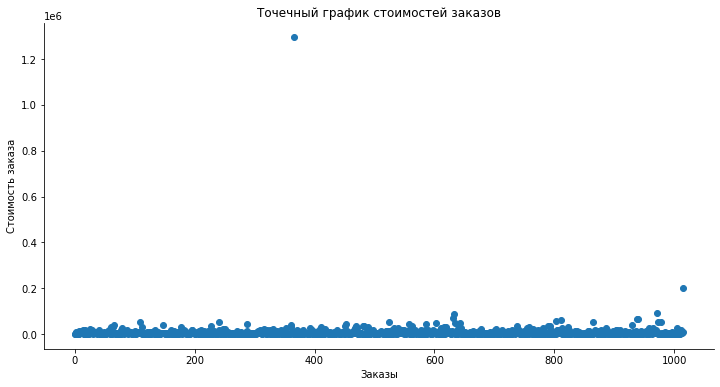

In [52]:
x_values = pd.Series(range(0, len(orders)))
plt.title('Точечный график стоимостей заказов')
plt.scatter(x_values, orders['revenue'])
plt.xlabel('Заказы')
plt.ylabel('Стоимость заказа');

Похоже, что есть всего два выброса. По графику кажется, что можно определить нижнюю границу аномальных значений как 20000. 

<a id='s39'></a>  
**3.10. Рассчитаем 95 и 99 перцентили стоимостей заказов.** 

In [53]:
revenue_percentiles = np.percentile(orders['revenue'], [95,99])
print(revenue_percentiles)

[26785. 53904.]


Только 5% пользователей делают заказы свыше 26785. Примем это число за нижнюю границу.

In [54]:
revenue_lower_limit = revenue_percentiles[0]

<a id='s311'></a>  
**3.11. Расчет статистической значимости различий в конверсии между двумя группами по "сырым" данным.** 

In [55]:
visitors_a_daily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

In [56]:
visitors_a_cumulative = visitors_a_daily.apply(lambda x: visitors_a_daily[
    visitors_a_daily['date']<=x['date']].agg({'date':'max',
                                             'visitors_per_date_a':'sum'}),
                                               axis=1)
visitors_a_cumulative.columns = ['date', 'visitors_cumulative_a']

In [57]:
visitors_b_daily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

In [58]:
visitors_b_cumulative = visitors_b_daily.apply(lambda x: visitors_b_daily[
    visitors_b_daily['date']<=x['date']].agg({'date':'max',
                                             'visitors_per_date_b':'sum'}),
                                               axis=1)
visitors_b_cumulative.columns = ['date', 'visitors_cumulative_b']

In [59]:
orders_a_daily = orders[orders['group']=='A'][
    ['date', 'transaction_id', 'visitor_id', 'revenue']].groupby(
    'date', as_index=False).agg({'transaction_id':'nunique',
                                'revenue':'sum'})
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_b_daily = orders[orders['group']=='B'][
    ['date', 'transaction_id', 'visitor_id', 'revenue']].groupby(
    'date', as_index=False).agg({'transaction_id':'nunique',
                                'revenue':'sum'})
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

In [60]:
orders_a_cumulative = orders_a_daily.apply(lambda x: orders_a_daily[
    orders_a_daily['date']<=x['date']].agg({'date':'max',
                        'orders_per_date_a':'sum',
                        'revenue_per_date_a':'sum'}), axis=1).sort_values(
    by='date')
orders_a_cumulative.columns = [
    'date', 'orders_cumulative_a', 'revenue_cumulative_a']

In [61]:
orders_b_cumulative = orders_b_daily.apply(lambda x: orders_b_daily[
    orders_b_daily['date']<=x['date']].agg({'date':'max',
                        'orders_per_date_b':'sum',
                        'revenue_per_date_b':'sum'}), axis=1).sort_values(
    by='date')
orders_b_cumulative.columns = [
    'date', 'orders_cumulative_b', 'revenue_cumulative_b']

In [62]:
cumulative_report = orders_a_daily.merge(orders_b_daily, on='date',
                                             how='left').merge(
orders_a_cumulative, on='date', how='left').merge(
orders_a_cumulative, on='date', how='left').merge(
visitors_a_daily, on='date', how='left').merge(
visitors_b_daily, on='date', how='left').merge(
visitors_a_cumulative, on='date', how='left').merge(
visitors_b_cumulative, on='date', how='left')

In [63]:
cumulative_report.head()

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cumulative_a_x,revenue_cumulative_a_x,orders_cumulative_a_y,revenue_cumulative_a_y,visitors_per_date_a,visitors_per_date_b,visitors_cumulative_a,visitors_cumulative_b
0,2019-08-01,23,142779,17,59758,23,142779,23,142779,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,42,234381,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,66,346854,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,77,388030,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,99,474413,756,707,3318,3280


In [64]:
orders_by_users_a = (orders[orders['group']=='A'].groupby(
    'visitor_id', as_index=False)
.agg({'transaction_id':'nunique'}))
orders_by_users_a.columns = ['visitor_id', 'orders']              

In [65]:
orders_by_users_b = (orders[orders['group']=='B'].groupby(
    'visitor_id', as_index=False)
.agg({'transaction_id':'nunique'}))
orders_by_users_b.columns = ['visitor_id', 'orders']

In [66]:
# введем переменные, содержащие информацию о количестве заказов
# каждого пользователя в группе, включая тех, кто ничего не купил
sample_a = pd.concat([orders_by_users_a['orders'], pd.Series(
    0, index=np.arange(cumulative_report['visitors_per_date_a'].sum()\
        - len(orders_by_users_a['orders'])),name='orders')], axis=0)
sample_b = pd.concat([orders_by_users_b['orders'], pd.Series(
    0, index=np.arange(cumulative_report['visitors_per_date_b'].sum()\
    - len(orders_by_users_b['orders'])), name='orders')], axis=0)

In [67]:
print('Относительный прирост конверсии группы B: {:.3f}'.format(
(sample_b.mean()/sample_a.mean())-1))

Относительный прирост конверсии группы B: 0.160


In [68]:
alpha = 0.05

Проверяем гипотезы:  
$H_0$: Между группами A и B нет различий в конверсии.  
$H_1$: Конверсия групп A и B различается.  

In [69]:
p_value_conv_raw = st.mannwhitneyu(sample_a, sample_b)[1]
print('p-значение:', str(p_value_conv_raw))

p-значение: 0.0055090420550073455


In [70]:
if p_value_conv_raw>alpha:
    print('Статистически значимых различий в конверсии между группами нет.')
else:
    print('Разница в конверсии между группами статистически значима.')

Разница в конверсии между группами статистически значима.


<a id='s312'></a>
**3.12. Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.**

Проверяем гипотезы:  
$H_0$: Средний чек групп A и B не различается.  
$H_1$: Средний чек групп A и B различается

In [71]:
print('Относительный прирост среднего чека группы B: {:.3f}'.format(
orders[orders['group']=='B']['revenue'].mean()/\
orders[orders['group']=='A']['revenue'].mean()-1))

Относительный прирост среднего чека группы B: 0.287


In [72]:
p_value_arpu_raw = st.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                          orders[orders['group']=='B']['revenue'])[1]
print('p-значение', str(p_value_arpu_raw))

p-значение 0.41474544990747664


In [73]:
if p_value_arpu_raw>alpha:
    print('Статистически значимых различий в среднем чеке между группами нет.')
else:
    print('Разница в среднем чеке между группами статистически значима.')

Статистически значимых различий в среднем чеке между группами нет.


<a id='s313'></a>  
**3.13. Расчет статистической значимости различий в конверсии между двумя группами по "очищенным" данным.**

Исключим из данных аномальные значения по вычисленным ранее границам.

In [74]:
users_with_many_orders = pd.concat([orders_by_users_a[
    orders_by_users_a['orders']>n_orders_lower_limit][
    'visitor_id'], orders_by_users_b[
    orders_by_users_b['orders']>n_orders_lower_limit][
    'visitor_id']], axis=0)

In [75]:
users_with_expensive_orders = orders[orders['revenue']>revenue_lower_limit][
    'visitor_id']

In [76]:
abnormal_users = pd.concat([users_with_many_orders,
                            users_with_expensive_orders],
                          axis=0).drop_duplicates().sort_values()

In [77]:
print('Всего выявлено ' + str(
    abnormal_users.shape[0]) + ' аномальных пользователей.')

Всего выявлено 58 аномальных пользователей.


Получим очищенные от аномалий данные.

In [78]:
sample_a_filtered = pd.concat([orders_by_users_a[~orders_by_users_a[
    'visitor_id'].isin(abnormal_users)]['orders'], pd.Series(
    0, index=np.arange(cumulative_report['visitors_per_date_a'].sum() - len(
    orders_by_users_a['orders'])),name='orders')],axis=0)

In [79]:
sample_b_filtered = pd.concat([orders_by_users_b[~orders_by_users_b[
    'visitor_id'].isin(abnormal_users)]['orders'], pd.Series(
    0, index=np.arange(cumulative_report['visitors_per_date_b'].sum() - len(
    orders_by_users_b['orders'])),name='orders')],axis=0)

In [80]:
print('Относительный прирост конверсии группы B: {:.3f}'.format(
(sample_b_filtered.mean()/sample_a_filtered.mean())-1))

Относительный прирост конверсии группы B: 0.182


Проверяем гипотезы:  
$H_0$: Между группами A и B нет различий в конверсии.  
$H_1$: Конверсия групп A и B различается. 

In [81]:
p_value_conv_filtered = st.mannwhitneyu(
    sample_a_filtered, sample_b_filtered)[1]
print('p-значение:', str(p_value_conv_filtered))

p-значение: 0.006176019008863195


In [82]:
if p_value_conv_filtered>alpha:
    print('Статистически значимых различий в конверсии между группами нет.')
else:
    print('Разница в конверсии между группами статистически значима.')

Разница в конверсии между группами статистически значима.


Удаление аномальных значений не повлияло на статистческую значимость различия в конверсии между группами.

<a id='s314'></a>
**3.14. Расчет статистической значимости различий в среднем чеке между двумя группами по "очищенным" данным.**

In [83]:
revenues_a = orders[(orders['group']=='A') & (~orders['visitor_id'].isin(
abnormal_users))]['revenue']

In [84]:
revenues_b = orders[(orders['group']=='B') & (~orders['visitor_id'].isin(
abnormal_users))]['revenue']

In [85]:
print('Относительный прирост среднего чека группы B: {:.3f}'.format(
revenues_b.mean()/revenues_a.mean()-1))

Относительный прирост среднего чека группы B: -0.048


После удаления аномалий группа B даже немного проигрывает. Рассчитаем статистическую значимость.

Гипотезы:  
$H_0$: Средний чек групп A и B не различается.  
$H_1$: Средний чек групп A и B различается.

In [86]:
p_value_arpu_filtered = st.mannwhitneyu(revenues_a, revenues_b)[1]
print('p-значение:', str(p_value_arpu_filtered))

p-значение: 0.3229482019045603


In [87]:
if p_value_arpu_filtered>alpha:
    print('Статистически значимых различий в среднем чеке между группами нет.')
else:
    print('Разница в среднем чеке между группами статистически значима.')

Статистически значимых различий в среднем чеке между группами нет.


<a id='s315'></a>
**3.15. Решение по результатам теста**

* Выявлено статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.  
* По среднему чеку, напротив, нет статистически значимого различия ни по сырым, ни по очищенным данным.  
* По графику относительного различия кумулятивной конверсии группы B к A видно, что по этому показателю группа B стабильно лучше.  
* По графику относительного различия среднего чека группы B к A видно, что преимущество группы B связано с аномальными по стоимости и количеству заказов зачениями.  

Решение по результатам теста: остановить тест, зафиксировать победу группы B по конверсии и отсутствие различий между группами по среднему чеку.

<a id='step4'></a>

# 4. Общий вывод

* Для приоритизации гипотез был выбран метод RICE, который использует более полную информацию о гипотезах: учитывает не только показатели  влияния на пользователей, уверенности в гипотезе и затраты ресурсов на проверку гипотезы, но и охват пользователей.  
* По выбранному методу наиболее приоритетной была выбрана гипотеза **Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**  
* Были собраны данные о 1197 заказах и агрегированные по дням данные о визитах за период с 1 по 31 августа 2019 года.  
* В ходе предобработки данных выяснилось, что есть пользователи, которые попали в обе группы. Поскольку по ним нельзя сказать, повлияло ли изменение на их поведение, таких пользователй было решено исключить из анализа.  
* Кроме того, были исключены пользователи с аномально большим числом заказов и аномально высокой стоимостью заказов. Такие покупки не связаны с тестированием гипотезы и могли появиться в любой из групп случайно.  
* По результатам A/B теста группа B побеждает по показателю конверсии. Статистически значимого различия в среднем чеке между группами не обнаружено.  

[К содержанию](#Содержание)